In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)

from deepymod_torch.library_function import *
from deepymod_torch.DeepMod import DeepMoD
from deepymod_torch.neural_net import *
from deepymod_torch.sparsity import *


np.random.seed(40)
%load_ext autoreload
%autoreload 2

#sys.path.append('../src/deepymod/')
#from DeepMoD import DeepMoD
#from library_functions import *
#from deepymod.utilities import library_matrix_mat, print_PDE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [171]:
def shift(test):
    return test[:-1]+np.diff(test)[0]/2

Loading in the data as a data-frame 

In [172]:
myFile_pd = pd.read_csv('../data/raw/SPT/Tracking_to_analyze.csv', sep=',')

In [173]:
myFile_pd.head()

,Frame,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7
0,0,630,359,934,627,1350,692,1236,383,1794,1021,1157,742,1007,836
1,1,630,360,933,626,1349,691,1235,382,1795,1021,1156,743,1007,837
2,2,630,360,932,628,1351,690,1234,383,1795,1021,1156,744,1007,836
3,3,631,360,932,628,1349,690,1235,383,1795,1021,1156,744,1006,837
4,4,630,359,932,628,1350,691,1233,383,1794,1022,1157,744,1007,839


Selecting the x and y values of the data and substacting the initial position to make all particles start at (x,y) = (0,0)

In [174]:
x_list = pd.concat([myFile_pd['x1'],myFile_pd['x2'],myFile_pd['x3'],myFile_pd['x4'],myFile_pd['x5'],myFile_pd['x6'],myFile_pd['x7']],axis=1)
y_list = pd.concat([myFile_pd['y1'],myFile_pd['y2'],myFile_pd['y3'],myFile_pd['y4'],myFile_pd['y5'],myFile_pd['y6'],myFile_pd['y7']],axis=1)
x_list = x_list-x_list.values.squeeze()[0]
y_list = y_list-y_list.values.squeeze()[0]

In [175]:
x_position_array = np.asarray(x_list.values.squeeze())
y_position_array = np.asarray(y_list.values.squeeze())

m is the amount of individual trajectories that you want to split your dataset into.

In [209]:
m = 105
L_cuts = np.int(x_position_array.shape[0]/m)
x_array = x_position_array[0:L_cuts][:,1:]
y_array = y_position_array[0:L_cuts][:,1:]

In [210]:
for i in range(1,m):
    temp_array_x= x_position_array[i*L_cuts:(i+1)*L_cuts] - x_position_array[i*L_cuts]
    temp_array_y= y_position_array[i*L_cuts:(i+1)*L_cuts] - y_position_array[i*L_cuts]
    x_array= np.hstack((x_array,temp_array_x[:,1:]))
    y_array= np.hstack((y_array,temp_array_y[:,1:]))

In [211]:
import seaborn as sns;

In [212]:
x_array.shape

(11, 630)

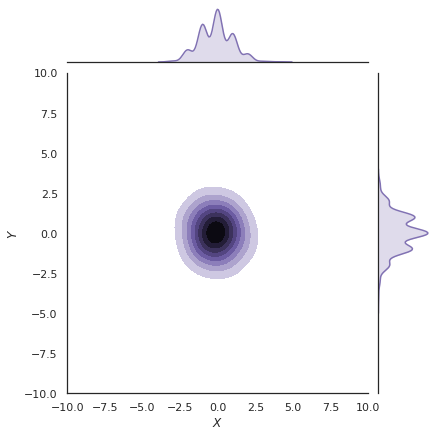

In [213]:
time=2
g = sns.jointplot(x=x_array[time],y=y_array[time], kind="kde", color="m",xlim=(-10,10),ylim=(-10,10), bw=0.75)
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$");

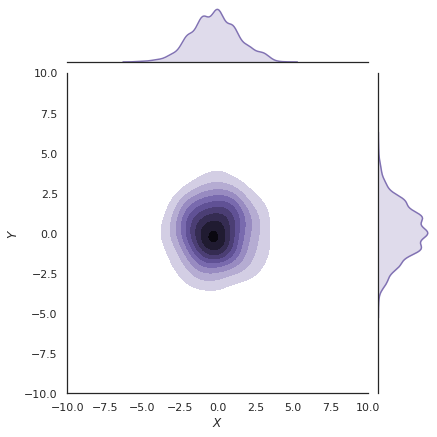

In [214]:
time=4
g = sns.jointplot(x=x_array[time],y=y_array[time], kind="kde", color="m",xlim=(-10,10),ylim=(-10,10), bw=0.75)
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$");

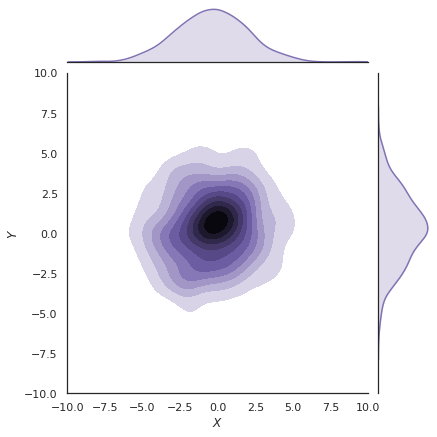

In [215]:
time=10
g = sns.jointplot(x=x_array[time],y=y_array[time], kind="kde", color="m",xlim=(-10,10),ylim=(-10,10), bw=0.75)
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$");

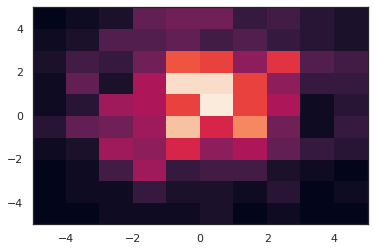

In [301]:
plt.hist2d(x=x_array[9],y=y_array[9],bins=10,range=[[-5,5],[-5,5]],density=True)
plt.show()

In [274]:
histo=np.histogram2d(x=x_array[0],y=y_array[0],bins=10,range=[[-5,5],[-5,5]])
U = np.empty(histo[0].shape).flatten()
x_m, y_m = np.meshgrid(histo[1].flatten()[:-1], histo[1].flatten()[:-1])
X_m= np.empty(x_m.shape).flatten()
Y_m= np.empty(y_m.shape).flatten()
T = np.empty(x_m.shape).flatten()

In [275]:
for t in range(1,len(x_array)):
    print(t)
    histo=np.histogram2d(x=x_array[t],y=y_array[t],bins=10,range=[[-5,5],[-5,5]])
    u = histo[0].flatten()
    x_m, y_m = np.meshgrid(shift(histo[1].flatten()), shift(histo[1].flatten()))
    t = t*np.ones_like(x_m).flatten()
    X_m = np.vstack([X_m,x_m.flatten()])
    Y_m = np.vstack([Y_m,y_m.flatten()])
    T = np.vstack([T,t])
    U = np.vstack([U,u])
X_m= X_m[1:]
Y_m= Y_m[1:]
T = T[1:]
U = U[1:]

1
2
3
4
5
6
7
8
9
10


In [276]:
X = np.transpose((T.flatten(),X_m.flatten(), Y_m.flatten()))
y = U.reshape((U.size, 1))

print(X.shape, y.shape)

(1000, 3) (1000, 1)


# DeepMoD

In [277]:
number_of_samples = 1000

idx = np.random.permutation(y.size)
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y[idx, :][:number_of_samples], dtype=torch.float32)

In [278]:
print(X_train.shape, y_train.shape)

torch.Size([1000, 3]) torch.Size([1000, 1])


In [279]:
optim_config = {'lambda': 10**-5, 'max_iterations': 10000}

In [280]:
network_config = {'input_dim': 3, 'hidden_dim': 20, 'layers': 3, 'output_dim': y_train.shape[1]}

In [281]:
library_config = {'type': library_1D_in_group_c, 'poly_order': 0, 'diff_order': 2}

In [282]:
network, coeff_vector_list, sparsity_mask_list = deepmod_init(network_config, library_config)

1


In [290]:
time_deriv_list, theta, coeff_vector_list = train_group(X_train, y_train, network, coeff_vector_list, sparsity_mask_list, library_config, optim_config)

Epoch | Total loss | MSE | PI | L1 
0 1.4E+00 1.1E+00 2.3E-01 1.2E-05
tensor([[-0.0061],
        [ 0.0259],
        [ 0.0508],
        [ 0.0066]], requires_grad=True)
2500 1.2E+00 9.9E-01 2.1E-01 1.2E-05
tensor([[-0.0117],
        [ 0.0222],
        [ 0.0479],
        [ 0.0043]], requires_grad=True)
5000 1.1E+00 9.0E-01 2.0E-01 1.2E-05
tensor([[-0.0215],
        [ 0.0179],
        [ 0.0463],
        [ 0.0044]], requires_grad=True)
7500 1.1E+00 8.4E-01 2.3E-01 1.2E-05
tensor([[-0.0292],
        [ 0.0120],
        [ 0.0449],
        [ 0.0047]], requires_grad=True)


In [291]:
X_all = torch.tensor(X, dtype=torch.float32, requires_grad=True) 
prediction_full = network(X_all)

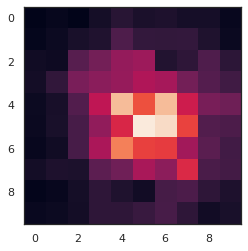

In [292]:
plt.imshow(prediction_full.detach().numpy().reshape(10,10,10)[8,:,:], aspect=1)

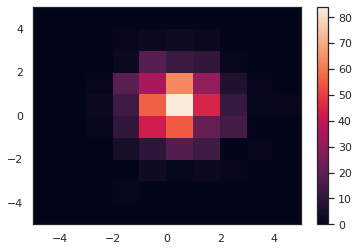

In [298]:
plt.hist2d(x=x_array[2],y=y_array[2],bins=10,range=[[-5,5],[-5,5]])
plt.colorbar()
plt.show()

# Find the maximal values

In [283]:
U = np.empty(histo[0].shape).flatten()
for t in range(1,len(x_array)):
    print(t)
    histo=np.histogram2d(x=x_array[t],y=y_array[t],bins=20,range=[[-10,10],[-10,10]])
    u = histo[0].flatten()
    x_m, y_m = np.meshgrid(histo[1].flatten()[:-1], histo[1].flatten()[:-1])
    t = np.ones_like(x_m).flatten()
    U = np.vstack([U,u])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [324]:
number_of_samples = 2000

idx = np.random.permutation(y.size)
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y[idx, :][:number_of_samples], dtype=torch.float32)

NameError: name 'torch' is not defined

In [161]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

im0 = axes[0].contourf(x_m, y_v, u, cmap='coolwarm')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('t = 0')

im1 = axes[1].contourf(x_v[:,:,10], y_v[:,:,10], u_v[:,:,10], cmap='coolwarm')
axes[1].set_xlabel('x')
axes[1].set_title('t = 10')

im2 = axes[2].contourf(x_v[:,:,20], y_v[:,:,20], u_v[:,:,20], cmap='coolwarm')
axes[2].set_xlabel('x')
axes[2].set_title('t= 20')

fig.colorbar(im1, ax=axes.ravel().tolist())

plt.show()

In [162]:
x_m.shape

(41, 1600)

In [132]:
for i in range(0,len(x_array)):
    histo=np.histogram2d(x=x_array[i],y=y_array[i],bins=40)[0]
    position_max=np.where(histo == np.amax(histo))
    if len(position_max[0]) ==1:
        print(np.squeeze(position_max))
    else:
        print(np.squeeze(position_max[0]))

[20 20]
[20 16]
[20 20]
[17 22]
[20 20]
[17 22]
[16 20]
[21 16]
[21 17]
[24 18]
[23 20]
[22 22]
[21 21]
[18 21]
[21 18]
[21 18]
[15 20]
[14 21]
[14 16]
[16 21]
[14 21]


In [113]:
histo=np.histogram2d(x=x_array[5],y=y_array[5],bins=20)[0]
position_max=np.where(histo == np.amax(histo))
print(position_max)

(array([ 8, 11]), array([11, 11]))


In [114]:
np.amax(histo)

20.0

In [117]:
len(np.where(histo == np.amax(histo)))

2